## Search for cycles and remove from fault networks  
Now included in main code

In [16]:
import pandas as pd
from map2loop import m2l_utils
from map2loop import m2l_interpolation
import numpy as np
import geopandas as gpd
import os
from shapely.geometry import Polygon
from math import sin, cos, atan, atan2, asin, radians, degrees, sqrt, pow, acos
import rasterio
from shapely.geometry import Point
from geopandas import GeoDataFrame
import networkx as nx

In [17]:
test_data_name='test_data3'

test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "../test_data3/m2l_config.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from ../test_data3/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=500057  #region of interest coordinates in metre-based system (or non-degree system)
maxx=603028
miny=7455348
maxy=7567953
model_top=1200
model_base=-8200

#PATHS

test_data_path='../test_data3/'
geology_file='hams2_geol.shp'   #input geology file (if local)
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
structure_file='hams2_structure.shp' #input bedding orientation file (if local)
m2m_cpp_path='../m2m_cpp/'


#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28350'} # coordinate system for data

#codes and labels these refer to specific fields (codes) in GIS layer or database that contain the info needed for these calcs and text substrings (labels) in the contents of these fie

[['Fault_12660', 'Fault_15552'], ['Fault_16825', 'Fault_7966', 'Fault_313', 'Fault_2837'], ['Fault_813', 'Fault_958', 'Fault_16503']]
[('Fault_313', 'Fault_2837'), ('Fault_2837', 'Fault_4721'), ('Fault_2837', 'Fault_16397'), ('Fault_2837', 'Fault_16825'), ('Fault_813', 'Fault_958'), ('Fault_958', 'Fault_815'), ('Fault_958', 'Fault_12641'), ('Fault_958', 'Fault_16503'), ('Fault_16503', 'Fault_813'), ('Fault_2225', 'Fault_16740'), ('Fault_16740', 'Fault_2227'), ('Fault_2235', 'Fault_2843'), ('Fault_2235', 'Fault_5252'), ('Fault_2235', 'Fault_5471'), ('Fault_2843', 'Fault_962'), ('Fault_5471', 'Fault_5252'), ('Fault_2248', 'Fault_16769'), ('Fault_16397', 'Fault_4721'), ('Fault_16397', 'Fault_16878'), ('Fault_16825', 'Fault_16503'), ('Fault_16825', 'Fault_7966'), ('Fault_16825', 'Fault_5463'), ('Fault_16825', 'Fault_16878'), ('Fault_16825', 'Fault_16816'), ('Fault_2840', 'Fault_3495'), ('Fault_2996', 'Fault_2840'), ('Fault_2996', 'Fault_3495'), ('Fault_2996', 'Fault_961'), ('Fault_2996', '

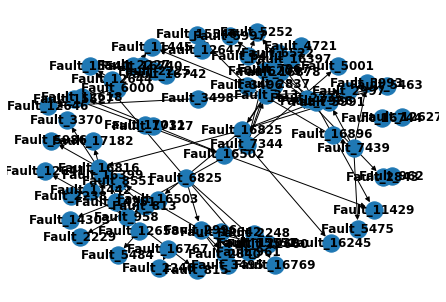

In [29]:
def parse_fault_network(graph_path,tmp_path,output_path):
    uf=open(graph_path+'unit-fault-intersection.txt','r')
    contents =uf.readlines()
    uf.close()
    
    all_long_faults=np.genfromtxt(output_path+'fault_dimensions.csv',delimiter=',',dtype='U25')
    n_faults=len(all_long_faults)
    #print(n_faults)
    all_faults={}
    unique_list = [] 
    #display(unique_list)
    for i in range(1,n_faults):
        f=all_long_faults[i][0]
        #print(all_long_faults[i][0])
        if f not in unique_list: 
            unique_list.append(f.replace("Fault_","")) 
    
    uf=open(graph_path+'fault-fault-intersection.txt','r')
    contents =uf.readlines()
    uf.close()
    #display(unique_list)
    unique_list_ff = [] 

    for row in contents:
        row=row.replace("\n","").split("{")
        fault_1o=row[0].split(',')
        fault_1o=fault_1o[1]
        
        faults_2o=row[1].replace("(","").replace(")","").replace("}","").split(",")

        if ((fault_1o.replace(" ","") not in unique_list_ff) and (fault_1o.replace(" ","") in unique_list)) : 
                unique_list_ff.append(fault_1o.replace(" ","")) 
        for i in range (0,len(faults_2o),3):
            if ((faults_2o[i].replace(" ","") not in unique_list_ff) and (faults_2o[i].replace(" ","") in unique_list)): 
                    unique_list_ff.append(faults_2o[i].replace(" ","")) 
    #display(unique_list) 
    
    G = nx.DiGraph()
    ff=open(output_path+'fault-fault-relationships.csv','w')
    ff.write('fault_id')
    for i in range (0,len(unique_list_ff)):
        ff.write(','+'Fault_'+unique_list_ff[i])
        G.add_node('Fault_'+unique_list_ff[i])
    ff.write('\n')

    for i in range(0,len(unique_list_ff)): #loop thorugh rows
        ff.write('Fault_'+unique_list_ff[i]) 
        found=False
        #for j in range(0,len(unique_list)):
        for row in contents: #loop thorugh known intersections
            row=row.replace("\n","").split("{")
            fault_1o=row[0].split(',')
            fault_1o=fault_1o[1]
            faults_2o=row[1].replace("(","").replace(")","").replace("}","").split(",")

            if(unique_list_ff[i].replace(" ","")==fault_1o.replace(" ","")): #correct first order fault for this row
                found=True
                for k in range(0,len(unique_list_ff)): #loop through columns
                    found2=False
                    if(k==i): # no self intersections
                        ff.write(',0')
                    else:
                        for f2o in range (0,len(faults_2o),3): #loop through second order faults for this row
                            if (faults_2o[f2o].replace(" ","")==unique_list_ff[k].replace(" ","")):
                                ff.write(',1')
                                G.add_edge('Fault_'+unique_list_ff[i], 'Fault_'+faults_2o[f2o].replace(" ",""))
                                found2=True
                                break

                    if(not found2 and k!=i):
                        ff.write(',0') #this is not a second order fault for this row
            if(found):
                break
        if(not found): #this fault is not a first order fault relative to another fault
            for i in range (0,len(unique_list_ff)):
                ff.write(',0')

        ff.write('\n')

    ff.close()

    nx.draw(G, with_labels=True, font_weight='bold')
    nx.write_gml(G, tmp_path+"fault_network.gml")  
    
    try:
        print(list(nx.simple_cycles(G)))
    except:
        print('no cycles')
        
    print(list(nx.simple_cycles(G)))
    print(list(G.edges))
    
    
parse_fault_network(graph_path,tmp_path,output_path)